In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from keras.layers import LSTM, RepeatVector, TimeDistributed, Input,Dense
from keras.models import Model,Sequential, model_from_json
from keras.constraints import max_norm

from copy import deepcopy
from calendar import timegm
import time
import sys
sys.path.append("../src")
import daily_imputation_rnn as dimp
import hourly_imputation_rnn as himp
import json

Using TensorFlow backend.


In [2]:
# Set plotting style, not essential
from jupyterthemes import jtplot
jtplot.style()
jtplot.style(ticks=True, grid=False, figsize=(24, 6))

# Import real data and transform it into a dataframe

In [3]:
# Hourly counts

real_data = pd.read_csv('../data/aggregatedCounts2016.csv', sep=',', names = ['areaid', 'devid', 'time', 'reportedcount1'], skiprows = [0])
print("locid possible values : ", list(set(real_data['areaid'])))
loc_id = 2
print('Using location:',  loc_id)
df = real_data.loc[np.where(real_data['areaid'] == loc_id)[0]]

start_epochs = np.array([timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S.%f")) for t in df['time']])
end_epochs = start_epochs + 3600 - 60 
df['reportedcount2'] = np.zeros(len(df['reportedcount1']))
df['startdt'] = start_epochs
df['enddt'] = end_epochs
df['level'] = "1h"
df['missing'] = 0
df['quality'] = 1
df = df.drop('time', 1)
df = df.drop('devid', 1)

locid possible values :  [2, 36, 10, 12, 44, 57]
Using location: 2


In [13]:
# 5 minute counts

real_data_5m = pd.read_csv('../data/5m_agg_counts_2016.csv', sep=',', names = ['areaid', 'devid', 'time', 'reportedcount1'], skiprows = [0])
print("locid possible values : ", list(set(real_data_5m['areaid'])))
loc_id = 36
df_5m = real_data_5m.loc[np.where(real_data_5m['areaid'] == loc_id)[0]]
print('Using location:',  loc_id)

start_epochs = np.array([timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S.%f")) for t in df_5m['time']])
end_epochs = start_epochs + 299 
df_5m['reportedcount2'] = np.zeros(len(df_5m['reportedcount1']))
df_5m['startdt'] = start_epochs
df_5m['enddt'] = end_epochs
df_5m['level'] = "5m"
df_5m['missing'] = 0
df_5m['quality'] = 1
df_5m = df_5m.drop('time', 1)
df_5m = df_5m.drop('devid', 1)

locid possible values :  [2, 36, 10, 44, 12, 57]
Using location: 36


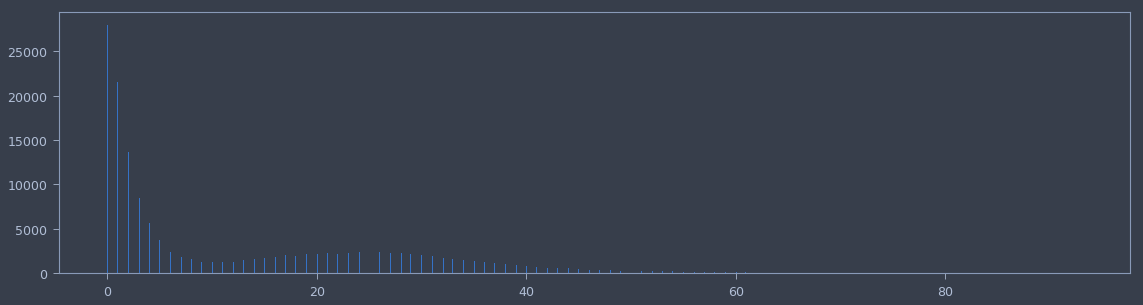

In [15]:
plt.hist(df_5m['reportedcount1'], bins = 1000)
plt.show()

In [ ]:
def get_dataframe(folder = '../data/aggregatedCounts2016.csv', locid = 2):
    """ Obtain and prepare real data from a legacy database.
    The format of the data is such that it should be almost identical to the one used in the pipeline.
    """
    real_data = pd.read_csv('../data/aggregatedCounts2016.csv', sep=',', names = ['areaid', 'devid', 'time', 'reportedcount1'], skiprows = [0])
    df = real_data.loc[np.where(real_data['areaid'] == locid)[0]]
                
    start_epochs = np.array([timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S.%f")) for t in df['time']])
    end_epochs = start_epochs + 3600 - 60 
    df['reportedcount2'] = np.zeros(len(df['reportedcount1']), dtype = int)
    df['startdt'] = start_epochs
    df['enddt'] = end_epochs
    df['level'] = "1h"
    df['missing'] = 0
    df['quality'] = 1
    df = df.drop('time', 1)
    df = df.drop('devid', 1)
    return df

In [114]:
def test_accuracy_5min(dataframe, train_days=30, test_days=20, fig_name=None):
    """ Function used to predict imputation accuracy on gaps of hours, days, and weeks.
        The model is trained and then tested on never-seen data which contains missing values
        which the model has to guess. Error is calculated as the % difference between the guess
        and the actual values of the observation at that time.
    """
    a = MinutePredictor(36)
    df_train = dataframe[:288*train_days]
    df_test = dataframe[288*train_days:288*(train_days+test_days)]
    a.train_from_dataframe(df_train)

    # Test on single hours missing, chosen at random
    missing_5mins = np.zeros(len(df_test))
    index_5mins = np.random.choice(
        np.arange(36, len(df_test)), size=36*test_days, replace=False)
    missing_5mins[index_5mins] = 1
    df_test_missing5mins = deepcopy(df_test)
    df_test_missing5mins['missing'] = missing_5mins
    y, t = a.impute_from_dataframe(df_test_missing5mins)

    mean_5min_perc_err_5min = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    print("Imputing 5 minute gaps:")
    print("Mean 5 mins  %% error on inputed data: %.2f %%" %
          (mean_5min_perc_err_5min))
    if fig_name is not None:
        a.plot_imputation(fig_name + "5min")
    else:
        a.plot_imputation()

    # Test on single days misisng, chosen at random
    missing_hours = np.zeros(len(df_test))
    index_hours = np.random.choice(
        np.arange(1, len(df_test)//12), size=3*test_days, replace=False)
    for i in index_hours:
        missing_hours[12*i:12*i+12] = 1
    df_test_missinghours = deepcopy(df_test)
    df_test_missinghours['missing'] = missing_hours
    y, t = a.impute_from_dataframe(df_test_missinghours)

    mean_5min_perc_err_hours = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    mean_hourly_perc_err_hours = 0
    for i in index_hours:
        mean_hourly_perc_err_hours += abs(100*(np.sum(t[12*i:12*i+12]) + 1)/(
            1 + np.sum(y[12*i:12*i+12])) - 100) / len(index_hours)

    print("Imputing hourly gaps:")
    print("Mean 5 mins  %% error on inputed data: %.2f %%" %
          (mean_5min_perc_err_hours))
    print("Mean hourly  %% error on inputed data: %.2f %%" %
          (mean_hourly_perc_err_hours))

    if fig_name is not None:
        a.plot_imputation(fig_name + "hourly")
    else:
        a.plot_imputation()

    # Test on single days misisng, chosen at random
    missing_days = np.zeros(len(df_test))
    index_days = np.random.choice(
        np.arange(1, test_days), size=test_days//10 + 1, replace=False)
    for i in index_days:
        missing_days[288*i:288*i+288] = 1
    df_test_missingdays = deepcopy(df_test)
    df_test_missingdays['missing'] = missing_days
    y, t = a.impute_from_dataframe(df_test_missingdays)

    mean_5min_perc_err_days = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    mean_hourly_perc_err_days = 0
    for i in index_days:
        for j in np.arange(24):
            mean_hourly_perc_err_days += abs(100*np.sum(t[288*i+12*j:288*i+12*j+12])/np.sum(
                y[288*i+12*j:288*i+12*j+12]) - 100) / len(index_days)/24

    mean_daily_perc_err_week = 0
    for i in index_days:
        mean_daily_perc_err_week += abs(100*np.sum(t[288*i:288*i+288])/np.sum(
            y[288*i:288*i+288]) - 100) / len(index_days)

    print("Imputing daily gaps:")
    print("Mean 5 mins %% error on inputed data: %.2f %%" %
          (mean_5min_perc_err_days))
    print("Mean hourly %% error on inputed data: %.2f %%" %
          (mean_hourly_perc_err_days))
    print("Mean daily  %% error on inputed data: %.2f %%" %
          (mean_daily_perc_err_week))

    if fig_name is not None:
        a.plot_imputation(fig_name + "daily")
    else:
        a.plot_imputation()

In [107]:
class MinutePredictor():
    def __init__(self, num5mins = 36):
        """ Initialize the prediction object.
        num5mins indicates the number of 5 minute segments before target to use in prediction. Default is 24.
        """
        self.num5mins = num5mins
        self.mu = None
        
    def reshape_data(self, data):
        """ Function used to reshape 5 minute counts into labels (Y) which contain a 5 minute count, 
        and features (X), which contain the 24 (or whatever self.num5mins is set to) previous 5 minute counts (X).
        """
        X = []  
        Y = []  
        for i in range(self.num5mins, len(data)):  
            X.append(data[i-self.num5mins:i])
            Y.append(data[i])

        X = np.array(X)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))  
        Y = np.reshape(np.array(Y), (len(Y), 1, 1))
        return(X, Y)        
        
    def train(self, training_data, epochs = 10, batchsize = 512, neurons = 100):
        """ Normalize input data, build the neural network, train the model.
        """
        self.normalized_train = self.normalize(training_data)
        self.X_train_norm, self.Y_train_norm = self.reshape_data(self.normalized_train)
        # Build model
        self.model = Sequential()
        self.model.add(LSTM(neurons, activation='linear', input_shape=(self.num5mins,1), 
                       kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
        self.model.add(RepeatVector(1))
        self.model.add(LSTM(neurons, activation='linear', return_sequences=True, 
                      kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
        self.model.add(TimeDistributed(Dense(1)))
        self.model.compile(optimizer='adam', loss='mse')
        # Train model
        self.history = self.model.fit(self.X_train_norm, self.Y_train_norm, 
                                      epochs=epochs, batch_size=batchsize, verbose=0, validation_split=0.2)
        
    def test(self, test_data):
        """ Normalize input data, test the model, denormalize and return true values and predictions
        """
        self.normalized_test = self.normalize(test_data)
        self.X_test_norm, self.Y_test_norm = self.reshape_data(self.normalized_test)
        self.Y_pred_norm = self.model.predict(self.X_test_norm)
        self.Y_pred = self.denormalize(self.Y_pred_norm)
        self.Y_test = self.denormalize(self.Y_test_norm)
        return self.Y_test, self.Y_pred
    
    def train_from_dataframe(self, train_dataframe, epochs = 10, batchsize = 512, neurons = 100):
        """ Train the model using a dataframe object as an input
        """
        cut_dataframe = self.cut_dataframe_at_midnight(train_dataframe)
        missing_labels = np.array(cut_dataframe['missing'], dtype = 'int')
        if all(missing_labels == 0):
            training_data = np.array(cut_dataframe['reportedcount1'])
            self.train(training_data, epochs, batchsize, neurons)
        else:
            print("ERROR: training dataframe cannot contain missing data. Shutting down.")
            exit()
               
    def test_from_dataframe(self, test_dataframe):
        """ Train the model using a dataframe object as an input
        """
        cut_dataframe = self.cut_dataframe_at_midnight(test_dataframe)
        test_data = np.array(cut_dataframe['reportedcount1'])
        test, pred = self.test(test_data)
        return test, pred
        
    def cut_times_at_midnight(self, times):
        """ Function used to get the index of the first 00:00 in an array of times
        """
        T_datetime = [datetime.fromtimestamp(t) for t in times]
        is_00 = np.array([t.hour == 0 for t in T_datetime])    
        start = np.where(is_00 == True)[0][0]
        return start
    
    def cut_dataframe_at_midnight(self, dataframe):
        """ Function used to cut at the first 00:00 of the dataframe object
        """
        times = dataframe['startdt']
        start_index = self.cut_times_at_midnight(times)
        cut_dataframe = dataframe[start_index:]
        return cut_dataframe
    
    def normalize(self, data):
        """ Used to perpare the data for the neural network.
        The average daily profile (typical behaviour of the 5-minute counts during a day)
        is obtained from the data. 
        We then take the log of the raw data and the log of the repeated daily profile, 
        get their difference, and then transform the result so that is has mean = 0 and 
        standard deviation = 1.
        """
        
        if self.mu is None:
            # Get the weekly profile and tile the dataset
            days_in_dataset = len(data)//288
            daily_profile = np.reshape(data[:days_in_dataset*288], (len(data)//288, 288))
            daily_profile = np.mean(daily_profile, axis = 0)
            self.daily_profile_single = daily_profile[:288]
            daily_profile = np.tile(daily_profile, len(data)//288 + 1)
            daily_profile = daily_profile[:len(data)]

            # Normalize by taking the logs of the counts and the weekly profile, and then subtracting them
            log_daily_profile = np.log(daily_profile+1) # +1 is here so that zeros do not break everything
            X_log = np.log(data+1)  # +1 is here so that zeros do not break everything
            X_notrend_log = X_log - log_daily_profile
            self.mu = np.mean(X_notrend_log)
            self.std = np.std(X_notrend_log, ddof = 1)
            
        else:
            daily_profile = np.tile(self.daily_profile_single, len(data)//288 + 1)
            daily_profile = daily_profile[:len(data)]
            X_notrend_log = np.log(data + 1) - np.log(daily_profile + 1) # +1 is here so that zeros do not break everything
            
        X_notrend_norm_log = (X_notrend_log - self.mu)/self.std 
        return X_notrend_norm_log
    
    def denormalize(self, data):
        """ Used to reconstruct the original data from the output of the neural network.
        Does the inverse operations of normalize
        """
        daily_profile_tile = np.tile(self.daily_profile_single, len(data)//288 + 1) # Tile for a week more
        daily_profile_tile = daily_profile_tile[:len(data)]  # And then cut at the data length
        data = data[:,0,0] # This is needed here otherwise the following operations get messy with dimensions
        X_notrend_log = data*self.std + self.mu
        log_daily_profile = np.log(daily_profile_tile+1)
        X_log = X_notrend_log + log_daily_profile
        X = np.exp(X_log) - 1
        return X
    
    def impute(self, data_to_impute, missing_labels):
        """ Look for data where the missing label is present an impute them based on the num5min 5-minute batches of previous data.
        While imputing, save the imputed values and replace missing data.
        """
        self.impute_data = data_to_impute
        self.missing_labels = missing_labels
        self.normalized_impute_data = self.normalize(self.impute_data)

        self.X_imputed_norm, _ = self.reshape_data(self.normalized_impute_data)
        self.Y_imputed_norm = np.reshape(self.normalized_impute_data, (len(self.normalized_impute_data), 1, 1))
        for i in np.where(self.missing_labels == 1)[0]:
            try:
                pred = self.model.predict(np.reshape(self.X_imputed_norm[i-self.num5mins,:,0], (1, self.num5mins, 1)))
                self.Y_imputed_norm[i] = pred
                for t in range(self.num5mins):
                    if(i+1-self.num5mins+t < len(self.X_imputed_norm)):
                        self.X_imputed_norm[i+1-self.num5mins+t,self.num5mins-1-t, 0] = pred
                        
            except:
                print("WARNING: Cannot impute data that has no counts for the previous %i 5-minute periods." %(self.num5mins))
                pass

        self.Y_imputed = self.denormalize(self.Y_imputed_norm)
        return self.impute_data, self.Y_imputed
    
    def impute_from_dataframe(self, dataframe):
        """ Impute from a dataframe object which has the "missing" label
        """
        cut_dataframe = self.cut_dataframe_at_midnight(dataframe)
        missing_labels = np.array(cut_dataframe['missing'], dtype = 'int')
        data_to_impute = np.array(cut_dataframe['reportedcount1'])
        test, pred = self.impute(data_to_impute, missing_labels)
        return test, pred
    
    def save(self, location = "../models/"):
        """ Save model and its normalization parameters to json,
        and model's weights to h5 files at location
        """
        # serialize model to JSON
        model_json = self.model.to_json()
        with open(location + "5min_imputation_model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights(location + "5min_imputation_model_weights.h5")
        
        parameters = {'mu' : self.mu, 'std': self.std, 'daily_profile': list(self.daily_profile_single)}
        with open(location + "5min_imputation_normalization_parameters.json", "w") as fp:
            json.dump(parameters, fp, indent=4)
            
        print("Saved model to disk")
        
    def load(self, location = "../models/"):
        """ Load model and its normalization parameters from json,
        and model's weights from h5 files at location
        """     
        # load json and create model
        json_file = open(location + '5min_imputation_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(location + "5min_imputation_model_weights.h5")
        self.model = loaded_model

        with open(location + '5min_imputation_normalization_parameters.json') as json_file:  
            parameters = json.load(json_file)
        self.mu, self.std = parameters['mu'], parameters['std']
        self.daily_profile_single = np.array(parameters['daily_profile'])
        print("Loaded model from disk")

    def plot_imputation(self, fig_name = None):
        plt.figure(figsize=(20,10))
        plt.plot(self.impute_data, label = 'Observed counts')
        plt.plot(self.Y_imputed, label = 'Imputed counts')
    
        plt.plot(np.arange(len(self.Y_imputed))[np.where(self.missing_labels == 1)[0]], 
            np.zeros(len(self.Y_imputed))[np.where(self.missing_labels == 1)[0]], 'r.', label = 'Missing data')
        plt.xlabel('5 min batch')
        plt.ylabel('5 Minute Counts')
        plt.legend()
        if fig_name is not None:
            plt.savefig(fig_name + ".png", dpi=80)
            plt.close()
        else:
            plt.show()

In [66]:
a = MinutePredictor(36)
a.train_from_dataframe(df_5m[:10000], epochs = 10, batchsize = 512, neurons = 100)

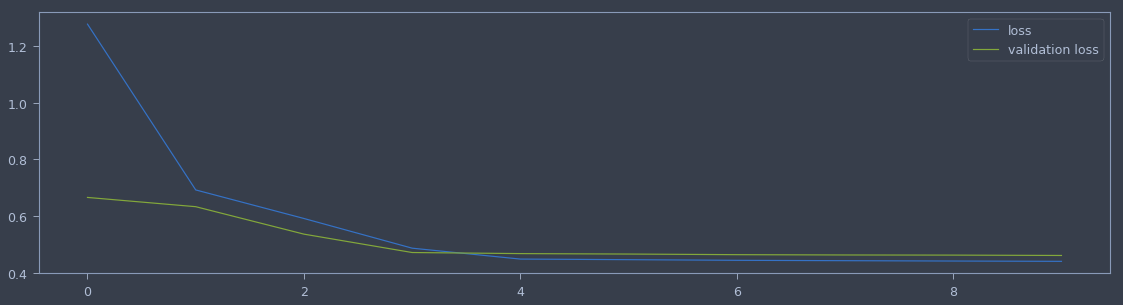

In [67]:
plt.plot(a.history.history['loss'], label = 'loss')
plt.plot(a.history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.show()

26.92594921034647


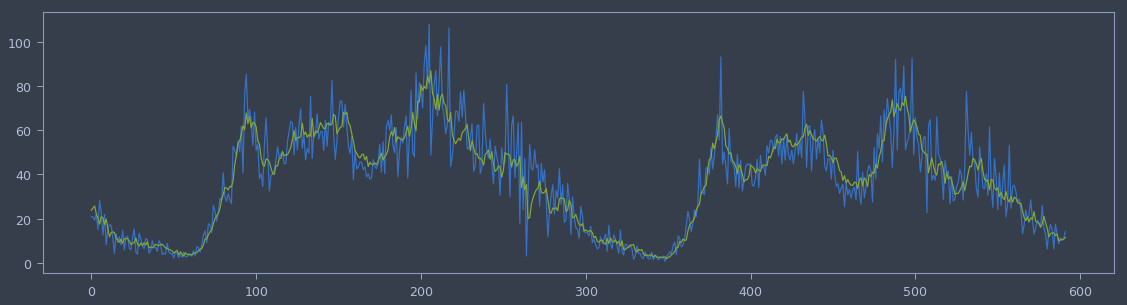

In [102]:
y, t = a.test_from_dataframe(df_5m[10000:10000+288*3 + 8])
print(np.mean(abs(100*t/y - 100)))
plt.plot(y)
plt.plot(t)
plt.show()

In [99]:
y_daily = np.reshape(y, (len(y)//288, 288))
y_daily = np.sum(y_daily, axis =1 )
t_daily = np.reshape(t, (len(y)//288, 288))
t_daily = np.sum(t_daily, axis =1 )
print(np.mean(abs(100*t_daily/y_daily - 100)))

4.142170373103767


Imputing 5 minute gaps:
Mean 5 mins  % error on inputed data: 23.71 %


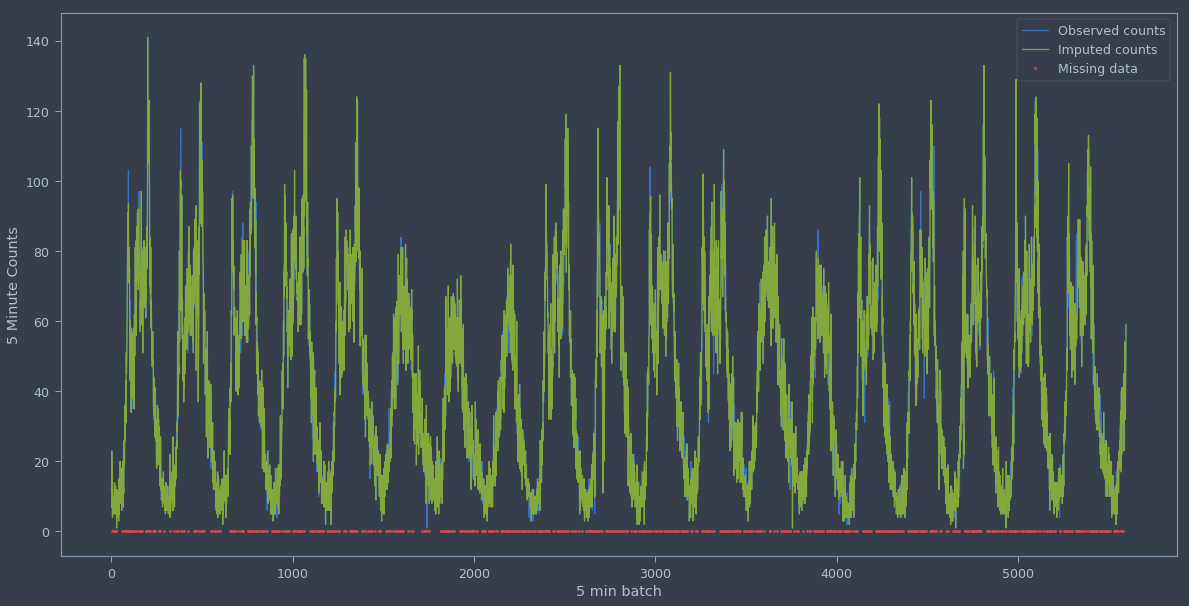

Imputing hourly gaps:
Mean 5 mins  % error on inputed data: 26.14 %
Mean hourly  % error on inputed data: 1.60 %


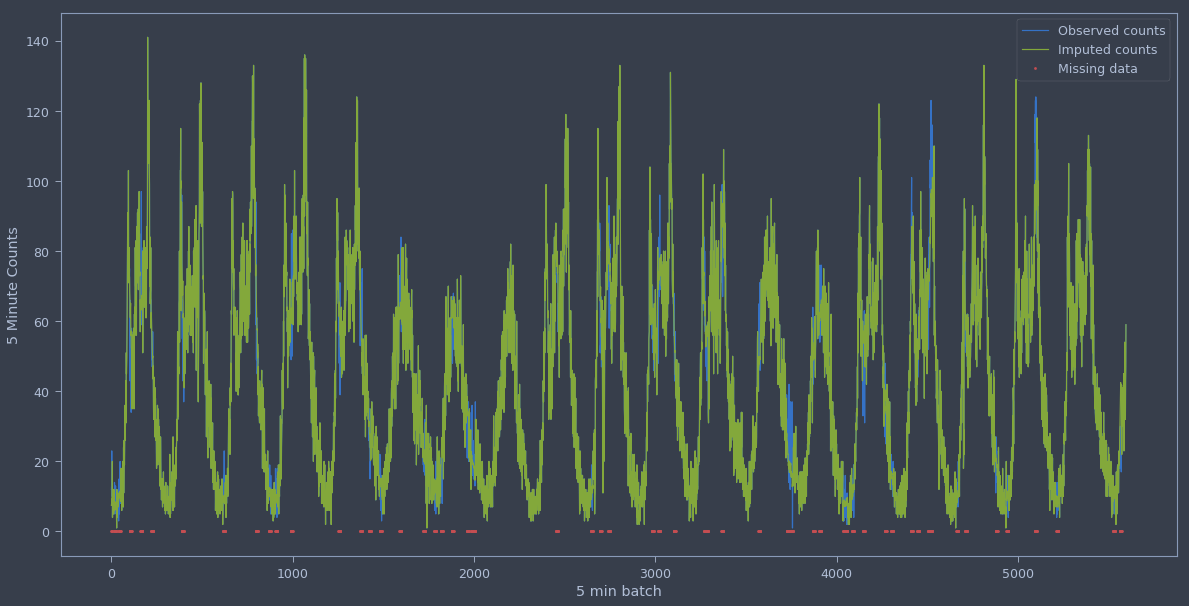

Imputing daily gaps:
Mean 5 mins % error on inputed data: 34.61 %
Mean hourly % error on inputed data: 13.56 %
Mean daily  % error on inputed data: 2.20 %


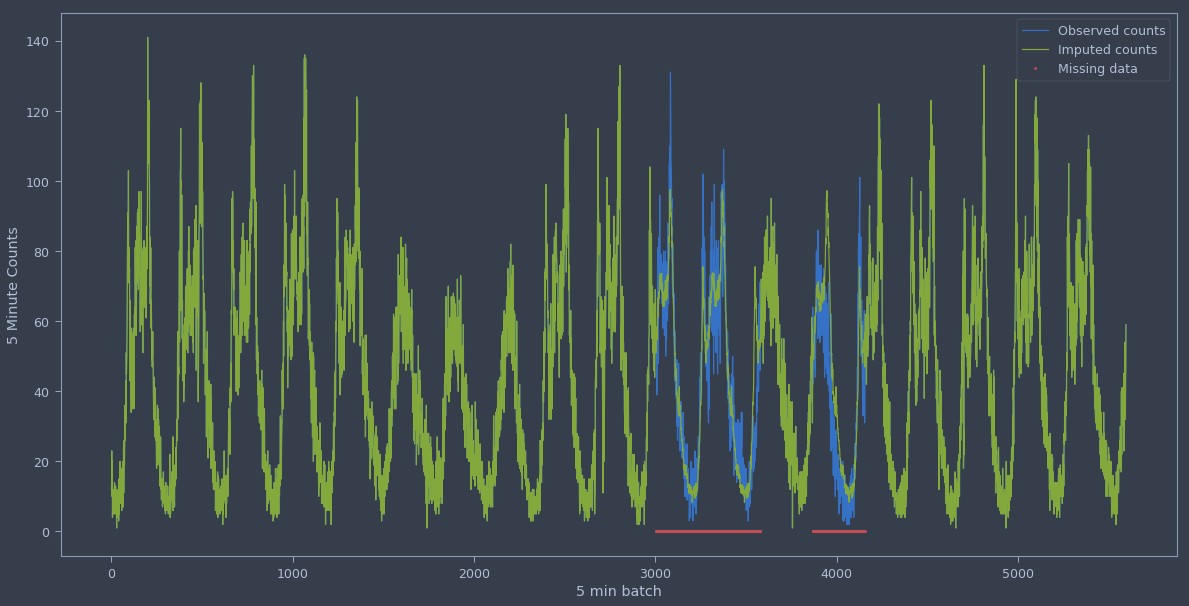

In [115]:
test_accuracy_5min(df_5m)

In [ ]:
import click
import time
import json
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from keras.layers import LSTM, RepeatVector, TimeDistributed, Input, Dense
from keras.models import Model, Sequential, model_from_json
from keras.constraints import max_norm
from copy import deepcopy
from calendar import timegm


class HourlyPredictor():
    def __init__(self, numhours=24):
        """ Initialize the prediction object.
        Numhours indicates the number of hours before target to use in prediction. Default is 24.
        """
        self.numhours = numhours
        self.mu = None

    def reshape_data(self, data):
        """ Function used to reshape hourly counts into labels (Y) which contain an hourly count, 
        and features (X), which contain the 24 (or whatever self.numhours is set to) previous hourly counts (X).
        """
        X = []
        Y = []
        for i in range(self.numhours, len(data)):
            X.append(data[i-self.numhours:i])
            Y.append(data[i])

        X = np.array(X)
        X = np.reshape(X, (X.shape[0], X.shape[1], 1))
        Y = np.reshape(np.array(Y), (len(Y), 1, 1))
        return(X, Y)

    def train(self, training_data, epochs=35, batchsize=256, neurons=50):
        """ Normalize input data, build the neural network, train the model.
        """
        self.normalized_train = self.normalize(training_data)
        self.X_train_norm, self.Y_train_norm = self.reshape_data(
            self.normalized_train)
        # Build model
        self.model = Sequential()
        self.model.add(LSTM(neurons, activation='linear', input_shape=(self.numhours, 1),
                            kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
        self.model.add(RepeatVector(1))
        self.model.add(LSTM(neurons, activation='linear', return_sequences=True,
                            kernel_constraint=max_norm(3), recurrent_constraint=max_norm(3), bias_constraint=max_norm(3)))
        self.model.add(TimeDistributed(Dense(1)))
        self.model.compile(optimizer='adam', loss='mse')
        # Train model
        self.history = self.model.fit(self.X_train_norm, self.Y_train_norm, epochs=epochs,
                                      batch_size=batchsize, verbose=0, validation_split=0.2)

    def test(self, test_data):
        """ Normalize input data, test the model, denormalize and return true values and predictions
        """
        self.normalized_test = self.normalize(test_data)
        self.X_test_norm, self.Y_test_norm = self.reshape_data(
            self.normalized_test)
        self.Y_pred_norm = self.model.predict(self.X_test_norm)
        self.Y_pred = self.denormalize(self.Y_pred_norm)
        self.Y_test = self.denormalize(self.Y_test_norm)
        return self.Y_test, self.Y_pred

    def train_from_dataframe(self, train_dataframe, epochs=35, batchsize=256, neurons=50):
        """ Train the model using a dataframe object as an input
        """
        cut_dataframe = self.cut_dataframe_at_mondays(train_dataframe)
        missing_labels = np.array(cut_dataframe['missing'], dtype='int')
        if all(missing_labels == 0):
            training_data = np.array(cut_dataframe['reportedcount1'])
            self.train(training_data, epochs, batchsize, neurons)
        else:
            print("ERROR: training dataframe cannot contain missing data. Shutting down.")
            exit()

    def test_from_dataframe(self, test_dataframe):
        """ Train the model using a dataframe object as an input
        """
        cut_dataframe = self.cut_dataframe_at_mondays(test_dataframe)
        test_data = np.array(cut_dataframe['reportedcount1'])
        test, pred = self.test(test_data)
        return test, pred

    def cut_times_at_mondays(self, times):
        """ Function used to get the index of the first 00:00 Monday in an array of times
        """
        T_datetime = [datetime.fromtimestamp(t) for t in times]
        is_monday = np.array([t.weekday() == 0 for t in T_datetime])
        is_00 = np.array([t.hour == 0 for t in T_datetime])
        start = np.where(is_00*is_monday == True)[0][0]
        return start

    def cut_dataframe_at_mondays(self, dataframe):
        """ Function used to cut at the first 00:00 Monday a dataframe object
        """
        times = dataframe['startdt']
        start_index = self.cut_times_at_mondays(times)
        cut_dataframe = dataframe[start_index:]
        return cut_dataframe

    def normalize(self, data):
        """ Used to perpare the data for the neural network.
        The average weekly profile (typical behaviour of the hourly counts during a week)
        is obtained from the data. 
        We then take the log of the raw data and the log of the repeated weekly profile, 
        get their difference, and then transform the result so that is has mean = 0 and 
        standard deviation = 1.
        """

        if self.mu is None:
            # Get the weekly profile and tile the dataset
            weeks_in_dataset = len(data)//168
            weekly_profile = np.reshape(
                data[:weeks_in_dataset*168], (len(data)//168, 168))
            weekly_profile = np.mean(weekly_profile, axis=0)
            self.weekly_profile_single = weekly_profile[:168]
            weekly_profile = np.tile(weekly_profile, len(data)//168 + 1)
            weekly_profile = weekly_profile[:len(data)]

            # Normalize by taking the logs of the counts and the weekly profile, and then subtracting them
            # +1 is here so that zeros do not break everything
            log_weekly_profile = np.log(weekly_profile+1)
            # +1 is here so that zeros do not break everything
            X_log = np.log(data+1)
            X_notrend_log = X_log - log_weekly_profile
            self.mu = np.mean(X_notrend_log)
            self.std = np.std(X_notrend_log, ddof=1)

        else:
            weekly_profile = np.tile(
                self.weekly_profile_single, len(data)//168 + 1)
            weekly_profile = weekly_profile[:len(data)]
            # +1 is here so that zeros do not break everything
            X_notrend_log = np.log(data + 1) - np.log(weekly_profile + 1)

        X_notrend_norm_log = (X_notrend_log - self.mu)/self.std
        return X_notrend_norm_log

    def denormalize(self, data):
        """ Used to reconstruct the original data from the output of the neural network.
        Does the inverse operations of normalize
        """
        weekly_profile_tile = np.tile(self.weekly_profile_single, len(
            data)//168 + 1)  # Tile for a week more
        # And then cut at the data length
        weekly_profile_tile = weekly_profile_tile[:len(data)]
        # This is needed here otherwise the following operations get messy with dimensions
        data = data[:, 0, 0]
        X_notrend_log = data*self.std + self.mu
        log_weekly_profile = np.log(weekly_profile_tile+1)
        X_log = X_notrend_log + log_weekly_profile
        X = np.exp(X_log) - 1
        return X

    def impute(self, data_to_impute, missing_labels):
        """ Look for data where the missing label is present an impute them based on the 24 hours of previous data.
        While imputing, save the imputed values and replace missing data.
        """
        self.impute_data = data_to_impute
        self.missing_labels = missing_labels
        self.normalized_impute_data = self.normalize(self.impute_data)

        self.X_imputed_norm, _ = self.reshape_data(self.normalized_impute_data)
        self.Y_imputed_norm = np.reshape(
            self.normalized_impute_data, (len(self.normalized_impute_data), 1, 1))
        for i in np.where(self.missing_labels == 1)[0]:
            try:
                pred = self.model.predict(np.reshape(
                    self.X_imputed_norm[i-self.numhours, :, 0], (1, self.numhours, 1)))
                self.Y_imputed_norm[i] = pred
                for t in range(self.numhours):
                    if(i+1-self.numhours+t < len(self.X_imputed_norm)):
                        self.X_imputed_norm[i+1-self.numhours +
                                            t, self.numhours-1-t, 0] = pred

            except:
                print("WARNING: Cannot impute data that has no counts for the previous %i hours." % (
                    self.numhours))
                pass

        self.Y_imputed = self.denormalize(self.Y_imputed_norm)
        return self.impute_data, self.Y_imputed

    def impute_from_dataframe(self, dataframe):
        """ Impute from a dataframe object which has the "missing" label
        """
        cut_dataframe = self.cut_dataframe_at_mondays(dataframe)
        missing_labels = np.array(cut_dataframe['missing'], dtype='int')
        data_to_impute = np.array(cut_dataframe['reportedcount1'])
        test, pred = self.impute(data_to_impute, missing_labels)
        return test, pred

    def save(self, location="../models/"):
        """ Save model and its normalization parameters to json,
        and model's weights to h5 files at location
        """
        # serialize model to JSON
        model_json = self.model.to_json()
        with open(location + "hourly_imputation_model.json", "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights(
            location + "hourly_imputation_model_weights.h5")

        parameters = {'mu': self.mu, 'std': self.std,
                      'weekly_profile': list(self.weekly_profile_single)}
        with open(location + "hourly_imputation_normalization_parameters.json", "w") as fp:
            json.dump(parameters, fp, indent=4)

        print("Saved model to disk")

    def load(self, location="../models/"):
        """ Load model and its normalization parameters from json,
        and model's weights from h5 files at location
        """
        # load json and create model
        json_file = open(location + 'hourly_imputation_model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        # load weights into new model
        loaded_model.load_weights(
            location + "hourly_imputation_model_weights.h5")
        self.model = loaded_model

        with open(location + 'hourly_imputation_normalization_parameters.json') as json_file:
            parameters = json.load(json_file)
        self.mu, self.std = parameters['mu'], parameters['std']
        self.weekly_profile_single = np.array(parameters['weekly_profile'])
        print("Loaded model from disk")

    def plot_imputation(self, fig_name=None):
        plt.figure(figsize=(20, 10))
        plt.plot(self.impute_data, label='Observed counts')
        plt.plot(self.Y_imputed, label='Imputed counts')

        plt.plot(np.arange(len(self.Y_imputed))[np.where(self.missing_labels == 1)[0]],
                 np.zeros(len(self.Y_imputed))[np.where(self.missing_labels == 1)[0]], 'r.', label='Missing data')
        plt.xlabel('Hour')
        plt.ylabel('Hourly Counts')
        plt.legend()
        if fig_name is not None:
            plt.savefig(fig_name + ".png", dpi=80)
            plt.close()
        else:
            plt.show()


def get_dataframe(folder='../data/aggregatedCounts2016.csv', locid=2):
    """ Obtain and prepare real data from a legacy database.
    The format of the data is such that it should be almost identical to the one used in the pipeline.
    """
    real_data = pd.read_csv('../data/aggregatedCounts2016.csv', sep=',',
                            names=['areaid', 'devid', 'time', 'reportedcount1'], skiprows=[0])
    df = real_data.loc[np.where(real_data['areaid'] == locid)[0]]

    start_epochs = np.array(
        [timegm(time.strptime(t, "%Y-%m-%d %H:%M:%S.%f")) for t in df['time']])
    end_epochs = start_epochs + 3600 - 60
    df['reportedcount2'] = np.zeros(len(df['reportedcount1']), dtype=int)
    df['startdt'] = start_epochs
    df['enddt'] = end_epochs
    df['level'] = "1h"
    df['missing'] = 0
    df['quality'] = 1
    df = df.drop('time', 1)
    df = df.drop('devid', 1)
    return df


def test_accuracy(dataframe, train_weeks=7, test_weeks=10, fig_name=None):
    """ Function used to predict imputation accuracy on gaps of hours, days, and weeks.
        The model is trained and then tested on never-seen data which contains missing values
        which the model has to guess. Error is calculated as the % difference between the guess
        and the actual values of the observation at that time.
    """
    a = HourlyPredictor(24)
    df_train = dataframe[:168*train_weeks]
    df_test = dataframe[168*train_weeks:168*(train_weeks+test_weeks)]
    a.train_from_dataframe(df_train)

    # Test on single hours misisng, chosen at random
    missing_hours = np.zeros(len(df_test))
    index_hours = np.random.choice(
        np.arange(24, len(df_test)), size=24*test_weeks, replace=False)
    missing_hours[index_hours] = 1
    df_test_missinghours = deepcopy(df_test)
    df_test_missinghours['missing'] = missing_hours
    y, t = a.impute_from_dataframe(df_test_missinghours)

    mean_hourly_perc_err_hours = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    print("Imputing hourly gaps:")
    print("Mean hourly %% error on inputed data: %.2f %%" %
          (mean_hourly_perc_err_hours))
    if fig_name is not None:
        a.plot_imputation(fig_name + "hourly")
    else:
        a.plot_imputation()

    # Test on single days misisng, chosen at random
    missing_days = np.zeros(len(df_test))
    index_days = np.random.choice(
        np.arange(1, len(df_test)//24), size=test_weeks, replace=False)
    for i in index_days:
        missing_days[24*i:24*i+24] = 1
    df_test_missingdays = deepcopy(df_test)
    df_test_missingdays['missing'] = missing_days
    y, t = a.impute_from_dataframe(df_test_missingdays)

    mean_hourly_perc_err_days = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    mean_daily_perc_err_days = 0
    for i in index_days:
        mean_daily_perc_err_days += abs(100*(1+np.sum(t[24*i:24*i+24]))/(
            1+np.sum(y[24*i:24*i+24])) - 100) / len(index_days)

    print("Imputing daily gaps:")
    print("Mean hourly %% error on inputed data: %.2f %%" %
          (mean_hourly_perc_err_days))
    print("Mean daily  %% error on inputed data: %.2f %%" %
          (mean_daily_perc_err_days))

    if fig_name is not None:
        a.plot_imputation(fig_name + "daily")
    else:
        a.plot_imputation()

    # Test on single days misisng, chosen at random
    missing_week = np.zeros(len(df_test))
    index_week = np.random.choice(
        np.arange(1, test_weeks), size=test_weeks//7 + 1, replace=False)
    for i in index_week:
        missing_week[168*i:168*i+168] = 1
    df_test_missingweek = deepcopy(df_test)
    df_test_missingweek['missing'] = missing_week
    y, t = a.impute_from_dataframe(df_test_missingweek)

    mean_hourly_perc_err_week = np.mean(np.abs(
        100*t[np.where(a.missing_labels == 1)[0]]/y[np.where(a.missing_labels == 1)[0]] - 100))

    mean_daily_perc_err_week = 0
    for i in index_week:
        for j in np.arange(7):
            mean_daily_perc_err_week += abs(100*(1+np.sum(t[168*i+24*j:168*i+24*j+24]))/(
                1+np.sum(y[168*i+24*j:168*i+24*j+24])) - 100) / len(index_week)/7

    mean_weekly_perc_err_week = 0
    for i in index_week:
        mean_weekly_perc_err_week += abs(100*(1+np.sum(t[168*i:168*i+168]))/(
            1+np.sum(y[168*i:168*i+168])) - 100) / len(index_week)

    print("Imputing weekly gaps:")
    print("Mean hourly %% error on inputed data: %.2f %%" %
          (mean_hourly_perc_err_week))
    print("Mean daily  %% error on inputed data: %.2f %%" %
          (mean_daily_perc_err_week))
    print("Mean weekly %% error on inputed data: %.2f %%" %
          (mean_weekly_perc_err_week))

    if fig_name is not None:
        a.plot_imputation(fig_name + "weekly")
    else:
        a.plot_imputation()


@click.command()
# Location ID inside the dataframe
@click.option("--location", '-l', type=int, default=2)
# How many weeks to use in training, these are always the first weeks of the ones that are used
@click.option("--training_weeks", "-ntr", type=int, default=7)
# How many weeks to use in testing, these follow immediately the training weeks
@click.option("--test_weeks", "-ntst", type=int, default=10)
# Location where to save the model to, and load the model from
@click.option("--model_location", "-ml", type=str, default=None)
def main(location, training_weeks, test_weeks, model_location):

    df = get_dataframe(
        folder='../data/aggregatedCounts2016.csv', locid=location)
    test_accuracy(df, training_weeks, test_weeks,
                  fig_name="../plots/hourly_imputation_error_plot")


if __name__ == "__main__":
    main()